In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import datetime
import pmdarima as pm
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
import scipy.stats as st
import itertools
import warnings

In [2]:
# Checks for stationarity and returns the order of differencing required
def return_stationary(sales_orignal):
    ctr=0
    if adfuller(sales_orignal)[1]>0.05:
        while(ctr<=3):
            ctr+=1
            sales_orignal = sales_orignal - sales_orignal.shift(1)
            sales_orignal.dropna(inplace=True)
            if adfuller(sales_orignal)[1]<=0.05:
                break
            else:
                continue
    return ctr

In [3]:
# Generating training and testing Datasets required for time series modelling
def train_test_data_prep_ts(data,training_periods):
    train_data = data[:training_periods]
    test_data = data[training_periods:]
    return train_data,test_data

In [4]:
# Generated the input data required for forcasting values of test period using regression models
def train_test_data_prep_reg(data,periods_of_forecast,training_periods):
    test_periods=len(data)-training_periods
    sales = data.copy(deep=True)
    d = sales.columns[0]
    sales['Lag_p']=sales[d].shift(periods_of_forecast) # Lag for p periods
    sales['Lag_p1']=sales[d].shift(periods_of_forecast+1) # Lag for p+1 periods
    sales=sales.dropna()
    #Creating values for model metrics calculation
    x1_v,x2_v,y=sales['Lag_p'],sales['Lag_p1'],sales[d] #Storing values of lags(independent features) and actual sales(dependent feature) in series
    x1_v,x2_v,y=np.array(x1_v),np.array(x2_v),np.array(y) #Converting the series in array
    x1_v,x2_v,y=x1_v.reshape(-1,1),x2_v.reshape(-1,1),y.reshape(-1,1)
    final_x_v=np.concatenate((x1_v,x2_v),axis=1) # Series of independent features
    #print(final_x_v)
    X_train,X_test,y_train,y_test=final_x_v[:-test_periods],final_x_v[-test_periods:],y[:-test_periods],y[-test_periods:] #Splitting data in train and test
    return X_train,X_test,y_train,y_test

In [5]:
# Generated the input data required for forcasting future values using regression models
def reg_model_data_generator(data,periods):
    sales = data.copy(deep=True)
    d = sales.columns[0]
    sales['Lag_p']=sales[d].shift(periods) # Lag for p periods
    sales['Lag_p1']=sales[d].shift(periods+1) # Lag for p+1 periods
    sales=sales.dropna()
    x1,x2,y = np.array(sales['Lag_p']),np.array(sales['Lag_p1']),np.array(sales[d])
    x1,x2=x1.reshape(-1,1),x2.reshape(-1,1)
    x_model,y_model = np.concatenate((x1,x2),axis=1),y
    x1_pred,x2_pred = np.array(sales[d][-periods:]),np.array(sales[d][-(periods+1):-1])
    x1_pred,x2_pred=x1_pred.reshape(-1,1),x2_pred.reshape(-1,1)
    x_pred = np.concatenate((x1_pred,x2_pred), axis=1)
    return x_model,y_model,x_pred

In [6]:
# Returns the metrics (RMSE, MAPE, MAE) of the prediction models
def metrics(predictions,targets):
    return round(np.sqrt(((predictions - targets) ** 2).mean()),2),round((np.mean(np.abs((targets - predictions)/targets))*100),2), round(mae(targets, predictions),2)

# Functions for models

In [7]:
# 9 week Moving Average
def ma12_prediction(sales,periods_of_forecast):
    #sales = sales[[d]]
    model = ARIMA(sales, order=(0,0,9))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=periods_of_forecast)
    return predictions

In [8]:
#Auto ARIMA
def ar_prediction(sales,d,periods_of_forecast):
    model_auto = pm.auto_arima(sales[d], start_p=0, d=return_stationary(sales),start_q=0,
                          max_p = 5,max_d=2,max_q=5, m = 0, seasonal = False,
                          max_order=2,test='adf',error_action = 'ignore',
                          suppress_warnings =True,
                          stepwise =True,trace = True, n_fits=50)
    model_auto_fit = model_auto.fit(sales[d])
    predictions = model_auto_fit.predict(n_periods=periods_of_forecast)
    return predictions

In [9]:
# SARIMA
def sarima_prediction(sales,d,periods_of_forecast):
    p = q = range(0, 2)
    diff= range(0, 2)
    pdq = list(itertools.product(p, diff, q))
    ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
    for param in pdq:
        ARIMA_model = ARIMA(sales[d],order=param).fit()
        #print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
        ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
    ARIMA_AIC = ARIMA_AIC.sort_values(by='AIC',ascending=True)
    model=sm.tsa.statespace.SARIMAX(sales[d],order=(ARIMA_AIC['param'][ARIMA_AIC['param'].index[0]][0], ARIMA_AIC['param'][ARIMA_AIC['param'].index[0]][1], ARIMA_AIC['param'][ARIMA_AIC['param'].index[0]][2]),seasonal_order=(ARIMA_AIC['param'][ARIMA_AIC['param'].index[0]][0],ARIMA_AIC['param'][ARIMA_AIC['param'].index[0]][1],ARIMA_AIC['param'][ARIMA_AIC['param'].index[0]][2],12))
    results=model.fit()
    predictions=results.predict(start=sales.count()[0],end=sales.count()[0]+periods_of_forecast-1,dynamic=True)
    return predictions

In [10]:
# Random Forest
def rf_prediction(X_training,y_training,X_prediction):
    model=RandomForestRegressor(n_estimators=100,max_features=2, random_state=1)
    #Creating values for model metrics calculation
    model.fit(X_training,y_training) # Fitting the model
    predictions=model.predict(X_prediction) # Getting predictions for test phase
    return predictions

In [11]:
# XG Boost
def xgb_prediction(X_train,y_train,X_test):
    model = XGBRegressor()
    model.fit(X_train,y_train) # Fitting the model
    predictions=model.predict(X_test) # Getting predictions for test phase
    return predictions

In [12]:
# Display the plots of the predictions and actual values
def visualize(data,d,actual_values,prediction_test,prediction_future):
    fig = plt.figure(figsize=(12,6))
    plt.plot(actual_values)
    plt.plot(prediction_test)
    plt.legend(["Actual","Prediction"], loc ="lower right")
    fig = plt.figure(figsize=(12,6))
    plt.plot(data[d])
    plt.plot(prediction_future)
    plt.legend(["Actual","Prediction"], loc ="upper right")

In [13]:
# Returns the index of winner model
def win(df,models,metric,d):
    l=[]
    for i in range(len(models)):
        l.append(metrics(df[d],df[models[i]])[metric])
    min_index=0
    for i in range(len(l)):
        if l[i]<l[min_index]:
            min_index=i
    return min_index

In [14]:
# Display which model is winning
def display_winning_model(models,index):
    print(f'The winner model is {models[index]} model')

In [15]:
# Generating predictions of average of all models in test period
# def average_test(models_without_average):
#     test_values = {models_without_average[0]:ar_prediction(train_test_data_prep_ts(data,training_periods)[0],d,len(train_test_data_prep_ts(data,training_periods)[1])),models_without_average[1]:sarima_prediction(train_test_data_prep_ts(data,training_periods)[0],d,len(train_test_data_prep_ts(data,training_periods)[1])),models_without_average[2]:ma12_prediction(train_test_data_prep_ts(data,training_periods)[0],len(train_test_data_prep_ts(data,training_periods)[1])),models_without_average[3]: rf_prediction(train_test_data_prep_reg(data,forecast_periods,training_periods)[0],train_test_data_prep_reg(data,forecast_periods,training_periods)[2],train_test_data_prep_reg(data,forecast_periods,training_periods)[1]),models_without_average[4]:xgb_prediction(train_test_data_prep_reg(data,forecast_periods,training_periods)[0],train_test_data_prep_reg(data,forecast_periods,training_periods)[2],train_test_data_prep_reg(data,forecast_periods,training_periods)[1])}
#     data_test_pred = pd.DataFrame(columns=models_without_average)
#     for model in models_without_average:
#         data_test_pred[model]=test_values[model]
#     data_test_pred['Average']=data_test_pred[models].mean(axis=1)
#     return data_test_pred['Average']

In [16]:
# Computing average of all models
# def average_model(models_without_average):
#     pred_df = pd.DataFrame(columns=models_without_average)
#     for model in models_without_average:
#         pred_df[model]=prediction_values[model]
#     pred_df['Average']=pred_df[models_without_average].mean(axis=1)
#     return pred_df['Average']

In [37]:
# Returns the Dataframe of models and metrics
def metrics_table(data,data_test_pred,actual_data,list_metric,models,d):
    metrics_table=pd.DataFrame(columns=models)
    for i in models:
        metrics_table[i] = list(metrics(data_test_pred[i],actual_data))
    metrics_table['Metric']=list_metric
    metrics_table = metrics_table.set_index('Metric')
    return metrics_table

In [42]:
def main():
    warnings.filterwarnings('ignore')
    d = input('Enter the name of Product: ')
    data = pd.read_csv(f'{d}.csv', index_col='Date', parse_dates=True)
    models = ['ARIMA','SARIMA','Moving Average','Random Forest','XGBoost','Average'] #Change here when add/delete model
    models_without_average = ['ARIMA','SARIMA','Moving Average','Random Forest','XGBoost'] #Change here when add/delete model
    list_of_metrics=['RMSE','MAPE','MAE'] #Change here when add/delete metric
    testing_periods = int(input('Enter the time periods for testing: '))
    training_periods = len(data)-testing_periods
    #training_periods = int(input('Enter the time periods for training: ')) #Time period for training
    forecast_periods = int(input('Enter the time periods for forecast: ')) #Time period for testing
    # mapping of models with their predictions in the test period
    test_values = {models[0]:ar_prediction(train_test_data_prep_ts(data,training_periods)[0],d,len(train_test_data_prep_ts(data,training_periods)[1])),models[1]:sarima_prediction(train_test_data_prep_ts(data,training_periods)[0],d,len(train_test_data_prep_ts(data,training_periods)[1])),models[2]:ma12_prediction(train_test_data_prep_ts(data,training_periods)[0],len(train_test_data_prep_ts(data,training_periods)[1])),models[3]: rf_prediction(train_test_data_prep_reg(data,forecast_periods,training_periods)[0],train_test_data_prep_reg(data,forecast_periods,training_periods)[2],train_test_data_prep_reg(data,forecast_periods,training_periods)[1]),models[4]:xgb_prediction(train_test_data_prep_reg(data,forecast_periods,training_periods)[0],train_test_data_prep_reg(data,forecast_periods,training_periods)[2],train_test_data_prep_reg(data,forecast_periods,training_periods)[1])}
    # creating a data frame of predictions of all models including the average model
    test_df = train_test_data_prep_ts(data,training_periods)[1]
    for i in models_without_average:
        test_df[i]=test_values[i]
    test_df['Average']=test_df[models_without_average].mean(axis=1)
    # mapping of models with their predictions in the future
    prediction_values = {models[0]:ar_prediction(data,d,forecast_periods),models[1]:sarima_prediction(data,d,forecast_periods),models[2]:ma12_prediction(data,forecast_periods),models[3]:rf_prediction(reg_model_data_generator(data,forecast_periods)[0],reg_model_data_generator(data,forecast_periods)[1],reg_model_data_generator(data,forecast_periods)[2]),models[4]:xgb_prediction(reg_model_data_generator(data,forecast_periods)[0],reg_model_data_generator(data,forecast_periods)[1],reg_model_data_generator(data,forecast_periods)[2])}
    # Dictionary is created that maps the metric to a numeric value
    mapping_dict = {list_of_metrics[0]:0,list_of_metrics[1]:1,list_of_metrics[2]:2}
    # Takes the input of metric of choice from the user and stores it
    user_input_metric = input('Enter the metric: ')
    metric_index = mapping_dict[user_input_metric] #storing the index of metrics
    index_of_winner_model = win(test_df,models,metric_index,d) #storing the index of winner model
    display_winning_model(models,index_of_winner_model) #Display the name of winner model
    #Creating a Data Frame of predictions of all the models including the average of all models
    predict_df = pd.DataFrame(prediction_values[models[0]],columns=[models[0]])
    for i in range(1,len(models_without_average)):
        predict_df[models_without_average[i]]=prediction_values[models_without_average[i]]
    predict_df['Average']=predict_df[models_without_average].mean(axis=1)
    predict_df = predict_df.round(2)
    metrics_df = metrics_table(data,test_df,train_test_data_prep_ts(data,training_periods)[1][d],list_of_metrics,models,d)
    # Display predictions and plots
    display(predict_df)
    display(metrics_df)
    display(predict_df[models[index_of_winner_model]])
    visualize(data,d,train_test_data_prep_ts(data,training_periods)[1],test_df[models[index_of_winner_model]],predict_df[models[index_of_winner_model]])

Enter the name of Product: P1
Enter the time periods for testing: 4
Enter the time periods for forecast: 12
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=364.140, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=298.932, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=339.313, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=281.606, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=278.860, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=277.314, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=275.620, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=273.795, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=271.808, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=271.911, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=271.924, Time=0.05 sec
 ARIMA(3,0,2

,ARIMA,SARIMA,Moving Average,Random Forest,XGBoost,Average
2022-01-07,8.61,5.64,8.83,7.90,8.53,7.90
2022-01-14,9.71,8.26,9.90,12.42,12.79,10.62
2022-01-21,9.41,3.16,8.90,7.02,5.78,6.85
2022-01-28,9.65,7.50,9.89,9.48,11.11,9.52
2022-02-04,9.58,5.83,9.32,12.70,13.04,10.10
2022-02-11,9.64,6.99,9.40,12.13,12.03,10.04
2022-02-18,9.62,6.76,9.90,7.59,7.99,8.37
2022-02-25,9.63,5.88,9.46,10.32,10.52,9.16
2022-03-04,9.63,5.75,9.63,9.48,11.28,9.15
2022-03-11,9.63,5.07,9.57,12.86,15.13,10.45


,ARIMA,SARIMA,Moving Average,Random Forest,XGBoost,Average
Metric,,,,,,
RMSE,3.41,3.30,1.93,3.57,3.35,2.40
MAPE,50.89,45.51,26.85,49.38,43.12,36.20
MAE,2.93,2.93,1.69,3.38,3.01,2.21


2022-01-07    8.83
2022-01-14    9.90
2022-01-21    8.90
2022-01-28    9.89
2022-02-04    9.32
2022-02-11    9.40
2022-02-18    9.90
2022-02-25    9.46
2022-03-04    9.63
2022-03-11    9.57
2022-03-18    9.57
2022-03-25    9.57
Freq: W-FRI, Name: Moving Average, dtype: float64

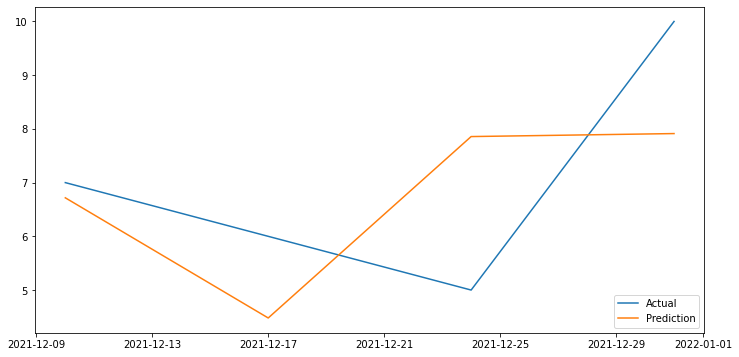

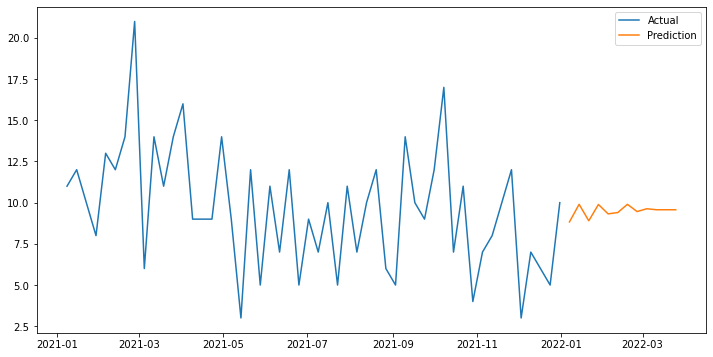

In [43]:
main()